In [1]:
# Import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn import metrics
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
import scipy.stats as stats

---
# Fitting a basic model

For the first model, we will use a simple model where all numerical columns are used. This is to get a rough idea of the data and whether it, on a base level, may be overfit or underfit.

In [2]:
# Load the .csvs that we cleaned
train = pd.read_csv('../data/train_clean.csv')
test = pd.read_csv('../data/test_clean.csv')

In [3]:
# Convert ID and PID columns to object dtype as they should not be considered a feature.
# Also convert ms_subclass to object as this should not be considered numerical
train.id = train.id.astype(object)
train.pid = train.pid.astype(object)
train.ms_subclass = train.ms_subclass.astype(object)

test.id = test.id.astype(object)
test.pid = test.pid.astype(object)
test.ms_subclass = test.ms_subclass.astype(object)

In [4]:
# Set the X and y
X = train.select_dtypes(include = (np.float64, np.int64)).drop(['saleprice'], axis = 1)
y = train.saleprice

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lot_frontage              2051 non-null   float64
 1   lot_area                  2051 non-null   int64  
 2   overall_qual              2051 non-null   int64  
 3   overall_cond              2051 non-null   int64  
 4   year_built                2051 non-null   int64  
 5   year_remod/add            2051 non-null   int64  
 6   masonry_veneer_area       2051 non-null   float64
 7   bsmtfin_sf_1              2051 non-null   float64
 8   bsmtfin_sf_2              2051 non-null   float64
 9   bsmt_unf_sf               2051 non-null   float64
 10  total_bsmt_sf             2051 non-null   float64
 11  1st_flr_sf                2051 non-null   int64  
 12  2nd_flr_sf                2051 non-null   int64  
 13  low_qual_fin_sf           2051 non-null   int64  
 14  above_gr

In [6]:
# Train-test-split the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [7]:
# Instantiate the model
lr = LinearRegression()

In [8]:
# Fit the model
lr.fit(X_train, y_train)

LinearRegression()

In [9]:
# Make predictions based on the model
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [10]:
# Score the model based on R2 value and RMSE
print(f'The R2 value of the training data is {lr.score(X_train, y_train)}.')
print(f'The R2 value of the test set is {lr.score(X_test, y_test)}.')
print(f'The RMSE of the training data is {metrics.mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'The RMSE of the test set is {metrics.mean_squared_error(y_test, y_test_pred, squared=False)}')

The R2 value of the training data is 0.8604571789336541.
The R2 value of the test set is 0.6464488286608747.
The RMSE of the training data is 30652.076992310725
The RMSE of the test set is 41241.54124522526


In [11]:
# Try K-folds cross validation

print(f'cv = 5: {cross_val_score(lr, X, y, cv=5).mean()}')
print(f'cv = 6: {cross_val_score(lr, X, y, cv=6).mean()}')
print(f'cv = 7: {cross_val_score(lr, X, y, cv=7).mean()}')
print(f'cv = 8: {cross_val_score(lr, X, y, cv=8).mean()}')
print(f'cv = 9: {cross_val_score(lr, X, y, cv=9).mean()}')
print(f'cv = 10: {cross_val_score(lr, X, y, cv=10).mean()}')


cv = 5: 0.7960696078714113
cv = 6: 0.7888588788826932
cv = 7: 0.7974047747569416
cv = 8: 0.7889174895874718
cv = 9: 0.7887570205608719
cv = 10: 0.7860420402612199


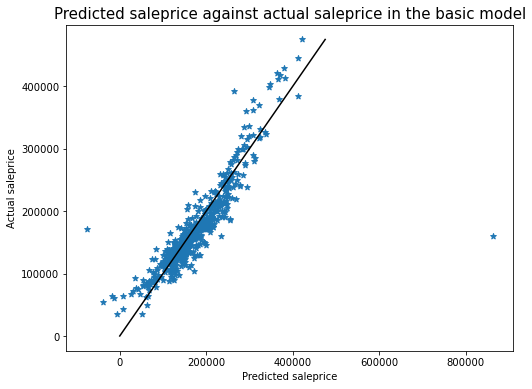

In [12]:
#Plots predicted values against actual values in the train/test split.
plt.figure(figsize=(8,6))
plt.scatter(y_test_pred, y_test,marker = '*')
plt.title('Predicted saleprice against actual saleprice in the basic model', fontsize=15)
plt.xlabel('Predicted saleprice')
plt.ylabel('Actual saleprice')

#Plots x=y line
plt.plot([0,np.max(y_test)],[0,np.max(y_test)], c = 'k');

plt.savefig(fname='../images/model1.png')

Although the plot of the predicted saleprice against actual saleprice looks good at first glance, with the predicted prices being packed closely to the perfect model, and the variance looking fairly even, we immediately notice a few glaring problems:  
1. There is a huge outlier in the predicted price which is very far from the actual saleprice.
2. There are negative predicted saleprices, and predicted saleprices close to zero.
  
This model seems to be unable to properly predict saleprices at the lower and higher ends of the scale. It seemss to more often overpredict prices in the midrange, while underpredicting prices in the lower and higher ranges.   


### Evaluating the basic model  

As the cross_val_scores are similar, we will use the default 5-folds as the cross_val_score.  
The $R^2$ value of the training data is 0.8604571789336541.  
The $R^2$ value of the test set is 0.6464488286608747.  
The RMSE of the training data is 30652.076992310725.  
The RMSE of the test set is 41241.54124522526.  
The cross validation score is 0.7960696078714113.   

Based on the $R^2$ and RMSE scores above, it seems that the values for the test data are lower in $R^2$ and higher in RMSE, suggesting that there is likely to be overfitting occurring, hence the model is not able to generalize well to new data.  
There is a high bias with low variance, suggesting low accuracy, and this can be seen from the scatterplot above, especially when it comes to the lower and higher ends of the predictions.  
This model should not be used as it has big problems such as the huge outlier with a high error, and negative predicted saleprices.

---
# Fitting a model with all object columns dummified

Since the basic model consisting of only numerical columns was not a very good model, we shall explore how the categorical columns will affect the model.  
To do this, we dummify, or one-hot-encode, the categorical columns to convert them to usable data for the modelling process.

In [13]:
# Load the .csvs that we cleaned
train2 = pd.read_csv('../data/train2_clean.csv')
test2 = pd.read_csv('../data/test2_clean.csv')

In [14]:
# Convert ID and PID columns to object dtype as they should not be considered a feature.
train2.id = train2.id.astype(object)
train2.pid = train2.pid.astype(object)

test2.id = test2.id.astype(object)
test2.pid = test2.pid.astype(object)

In [15]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Columns: 319 entries, id to sale_type_WD 
dtypes: float64(29), int64(288), object(2)
memory usage: 2.1+ MB


In [16]:
# Set the X and y
X2 = train2.select_dtypes(include = (np.float64, np.int64)).drop(['saleprice'], axis = 1)
y2 = train2.saleprice
test_X2 = test2.select_dtypes(include = (np.float64, np.int64))

In [17]:
# Train-test-split the training data
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.25, random_state=123)

In [18]:
# Instantiate and fit the model
lr2 = LinearRegression()
lr2.fit(X_train2, y_train2)

LinearRegression()

In [19]:
# Make predictions based on the model
y_test_pred2 = lr2.predict(X_test2)
y_train_pred2 = lr2.predict(X_train2)

In [20]:
# Score the model based on R2 value and RMSE
print(f'The R2 value of the training data is {lr2.score(X_train2, y_train2)}.')
print(f'The R2 value of the test data is {lr2.score(X_test2, y_test2)}.')
print(f'The RMSE of the training data is {metrics.mean_squared_error(y_train2, y_train_pred2, squared=False)}')
print(f'The RMSE of the test data is {metrics.mean_squared_error(y_test2, y_test_pred2, squared=False)}')
print(f'cv = 5: {cross_val_score(lr2, X2, y2, cv=5).mean()}')

The R2 value of the training data is 0.9454487032285156.
The R2 value of the test data is 0.6999733564685496.
The RMSE of the training data is 19164.99445304647
The RMSE of the test data is 37991.69399331487
cv = 5: 0.8496344461933412


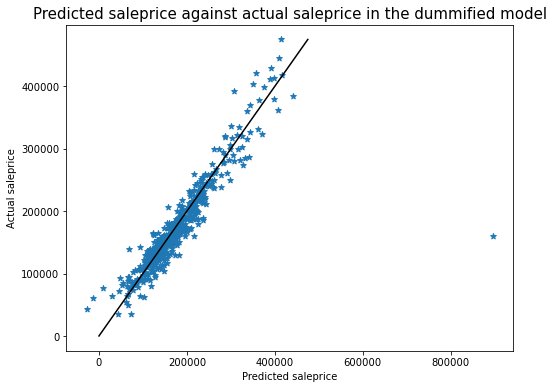

In [21]:
#Plot predicted saleprice against actual saleprice in the first model.
plt.figure(figsize=(8,6))
plt.scatter(y_test_pred2,y_test2,marker = '*')
plt.title('Predicted saleprice against actual saleprice in the dummified model', fontsize=15)
plt.xlabel('Predicted saleprice')
plt.ylabel('Actual saleprice')

#Plot perfect model line
plt.plot([0,np.max(y_test2)],[0,np.max(y_test2)], c = 'k');

plt.savefig(fname='../images/model2.png')

Although the plot of the predicted saleprice against actual saleprice once again looks good at first glance, with the predicted prices being packed closely to the perfect model, and the variance looking fairly even, we immediately notice that the previous few glaring problems are still present:  
1. There is a huge outlier in the predicted price which is very far from the actual saleprice.
2. There are negative predicted saleprices, and predicted saleprices close to zero.

### Evaluating the dummified model  

The $R^2$ value of the training data is 0.9454487032285156.
The $R^2$ value of the test data is 0.6999733564685496.
The RMSE of the training data is 19164.99445304647.
The RMSE of the test data is 37991.69399331487.  
The cross validation score is 0.8496344461933412.  

Based on the $R^2$ and RMSE scores above, once again, the values for the test data are much lower in $R^2$ and much higher in RMSE, suggesting that there is likely to be overfitting occurring. In fact, the overfitting is even more glaring here, with a difference in RMSE scores of nearly 20,000. What looked like a relatively good RMSE for the training data was vastly different in the test data due to the model's inability to generalize well to new data.  
There is high bias with low variance, suggesting low accuracy once again, and this can be seen from the scatterplot above, especially when it comes to the lower and higher ends of the predictions.  
This model should not be used as it still has big problems such as the huge outlier with a high error, and negative predicted saleprices.

---
# Feature Engineering a better  model

We realised that there are two different types of categorical features: ordinal and nominal features. Hence, it was not the best method to dummify all the columns.

Instead, we gave the ordinal features a numerical scale for their values. Next, we will only be picking features with correlation with saleprice of at least 0.5 to find the features with the most potential to affect saleprice.

In [22]:
# Load the .csvs that we cleaned
train3 = pd.read_csv('../data/train3_clean.csv')
test3 = pd.read_csv('../data/test3_clean.csv')

In [23]:
# Calculate correlations
correlations = train3.corr()
# Create new dataframe for the correlations with saleprice above 0.5
saleprice_corr = pd.DataFrame(correlations.saleprice[(correlations.saleprice > 0.5)].copy())
# Transpose this dataframe
saleprice_corr = pd.DataFrame(saleprice_corr.transpose())

In [24]:
# Remove saleprice from its own correlation
saleprice_corr.drop('saleprice', axis = 1, inplace=True)
# Create a list of features that we have narrowed down to
selected_columns = list(saleprice_corr.columns)

Now that we have a list of features with correlation of at least 0.5 with saleprice, we will check these columns for their correlations.

In [25]:
# Check correlation of selected features
selected_corr = train3[selected_columns].corr()

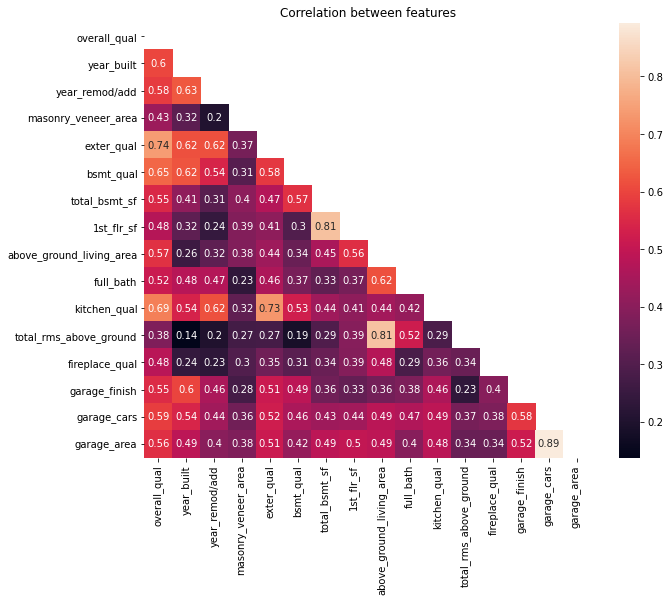

In [26]:
# Plot a heatmap of correlations
plt.figure(figsize = (10,8))
sns.heatmap(selected_corr, annot = True, mask=np.triu(selected_corr))
plt.title("Correlation between features")
plt.savefig(fname='../images/heatmap1.png')

As a measure, we are taking any correlations above 0.8 to be highly correlated.  
From the above heatmap, we can see that the following pairs of features are highly correlated:  
1. 1st_flr_sf with total_bsmt_sf;
2. total_rms_above_ground with above_ground_living_area;
3. garage_area with garage_cars  

Hence, we will drop one column from each of these pairs. We will drop the feature which has higher correlation with other features.  

In [27]:
# Find the sum of correlations for the features identified to be highly correlated.
np.sum(selected_corr[['1st_flr_sf','total_bsmt_sf','above_ground_living_area','total_rms_above_ground',
                      'garage_area','garage_cars']])

1st_flr_sf                  7.339381
total_bsmt_sf               7.653032
above_ground_living_area    8.011792
total_rms_above_ground      6.045167
garage_area                 8.215061
garage_cars                 8.438150
dtype: float64

In [28]:
# Among the pairs, total_bsmt
saleprice_corr.drop(['total_bsmt_sf','above_ground_living_area','garage_cars',], axis = 1, inplace=True)

In [29]:
# Update the list of the final selected columns
selected_columns = list(saleprice_corr.columns)

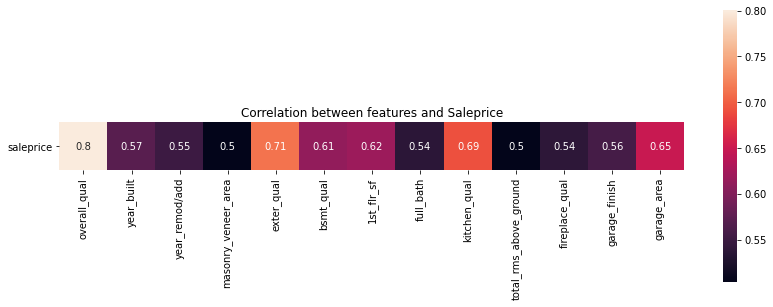

In [30]:
# Plot a heatmap to show correlation between the selected features and saleprice
plt.figure(figsize = (14,5))
sns.heatmap(saleprice_corr, annot = True,square = True)
plt.title("Correlation between features and Saleprice")
plt.yticks(rotation=0) 
plt.savefig(fname='../images/heatmap2.png')

As this heatmap shows, all the features selected have a correlation of over 0.5 with saleprice, and we will use them as our predictor features.  

Our assumption is that these features will have the biggest impact on the saleprice. Hence we will use them for our model fitting. These will be our 'top features'.  


In [31]:
# Create new X and y variables for this model using only selected features
X3 = train3[selected_columns]
y3 = train3.saleprice
test_X3 = test3[selected_columns]
train3_trimmed = X3.join(y3)

In [32]:
# Train-test-split the training data
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.25, random_state=123)

In [33]:
# Fit the linear regression model
lr3 = LinearRegression()
lr3.fit(X_train3, y_train3)

LinearRegression()

In [34]:
# Use the model to make predictions on the train and test splits
y_test_pred3 = lr3.predict(X_test3)
y_train_pred3 = lr3.predict(X_train3)

In [35]:
# Score the model based on R2 value and RMSE
print(f'The R2 value of the training data is {lr3.score(X_train3, y_train3)}.')
print(f'The R2 value of the test data is {lr3.score(X_test3, y_test3)}.')
print(f'The RMSE of the training data is {metrics.mean_squared_error(y_train3, y_train_pred3, squared=False)}')
print(f'The RMSE of the test data is {metrics.mean_squared_error(y_test3, y_test_pred3, squared=False)}')
print(f'cv = 5: {cross_val_score(lr3, X3, y3, cv=5).mean()}')

The R2 value of the training data is 0.8173729287388255.
The R2 value of the test data is 0.7755112881455641.
The RMSE of the training data is 35066.202439432716
The RMSE of the test data is 32862.90873764746
cv = 5: 0.8078216545569299


The scores have significantly improved from the previous model, where the $R^2$ and RMSE scores between the test and training set had a huge error margin.  
The $R^2$ and RMSE scores are much closer with this model, meaning it is more accurate, but there are still improvements that can be made. 

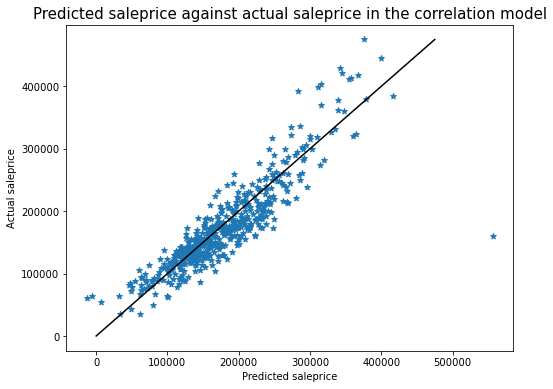

In [36]:
#Plots predicted values against actual values in the train/test split.
plt.figure(figsize=(8,6))
plt.scatter(y_test_pred3,y_test3,marker = '*')
plt.title('Predicted saleprice against actual saleprice in the correlation model', fontsize=15)
plt.xlabel('Predicted saleprice')
plt.ylabel('Actual saleprice')

#Plots x=y line
plt.plot([0,np.max(y_test3)],[0,np.max(y_test3)], c = 'k');

plt.savefig(fname='../images/model3.png')

This model is very similar to the previous, and the previous few glaring problems are still present:  
1. There is a huge outlier in the predicted price which is very far from the actual saleprice.
2. There are negative predicted saleprices, and predicted saleprices close to zero.

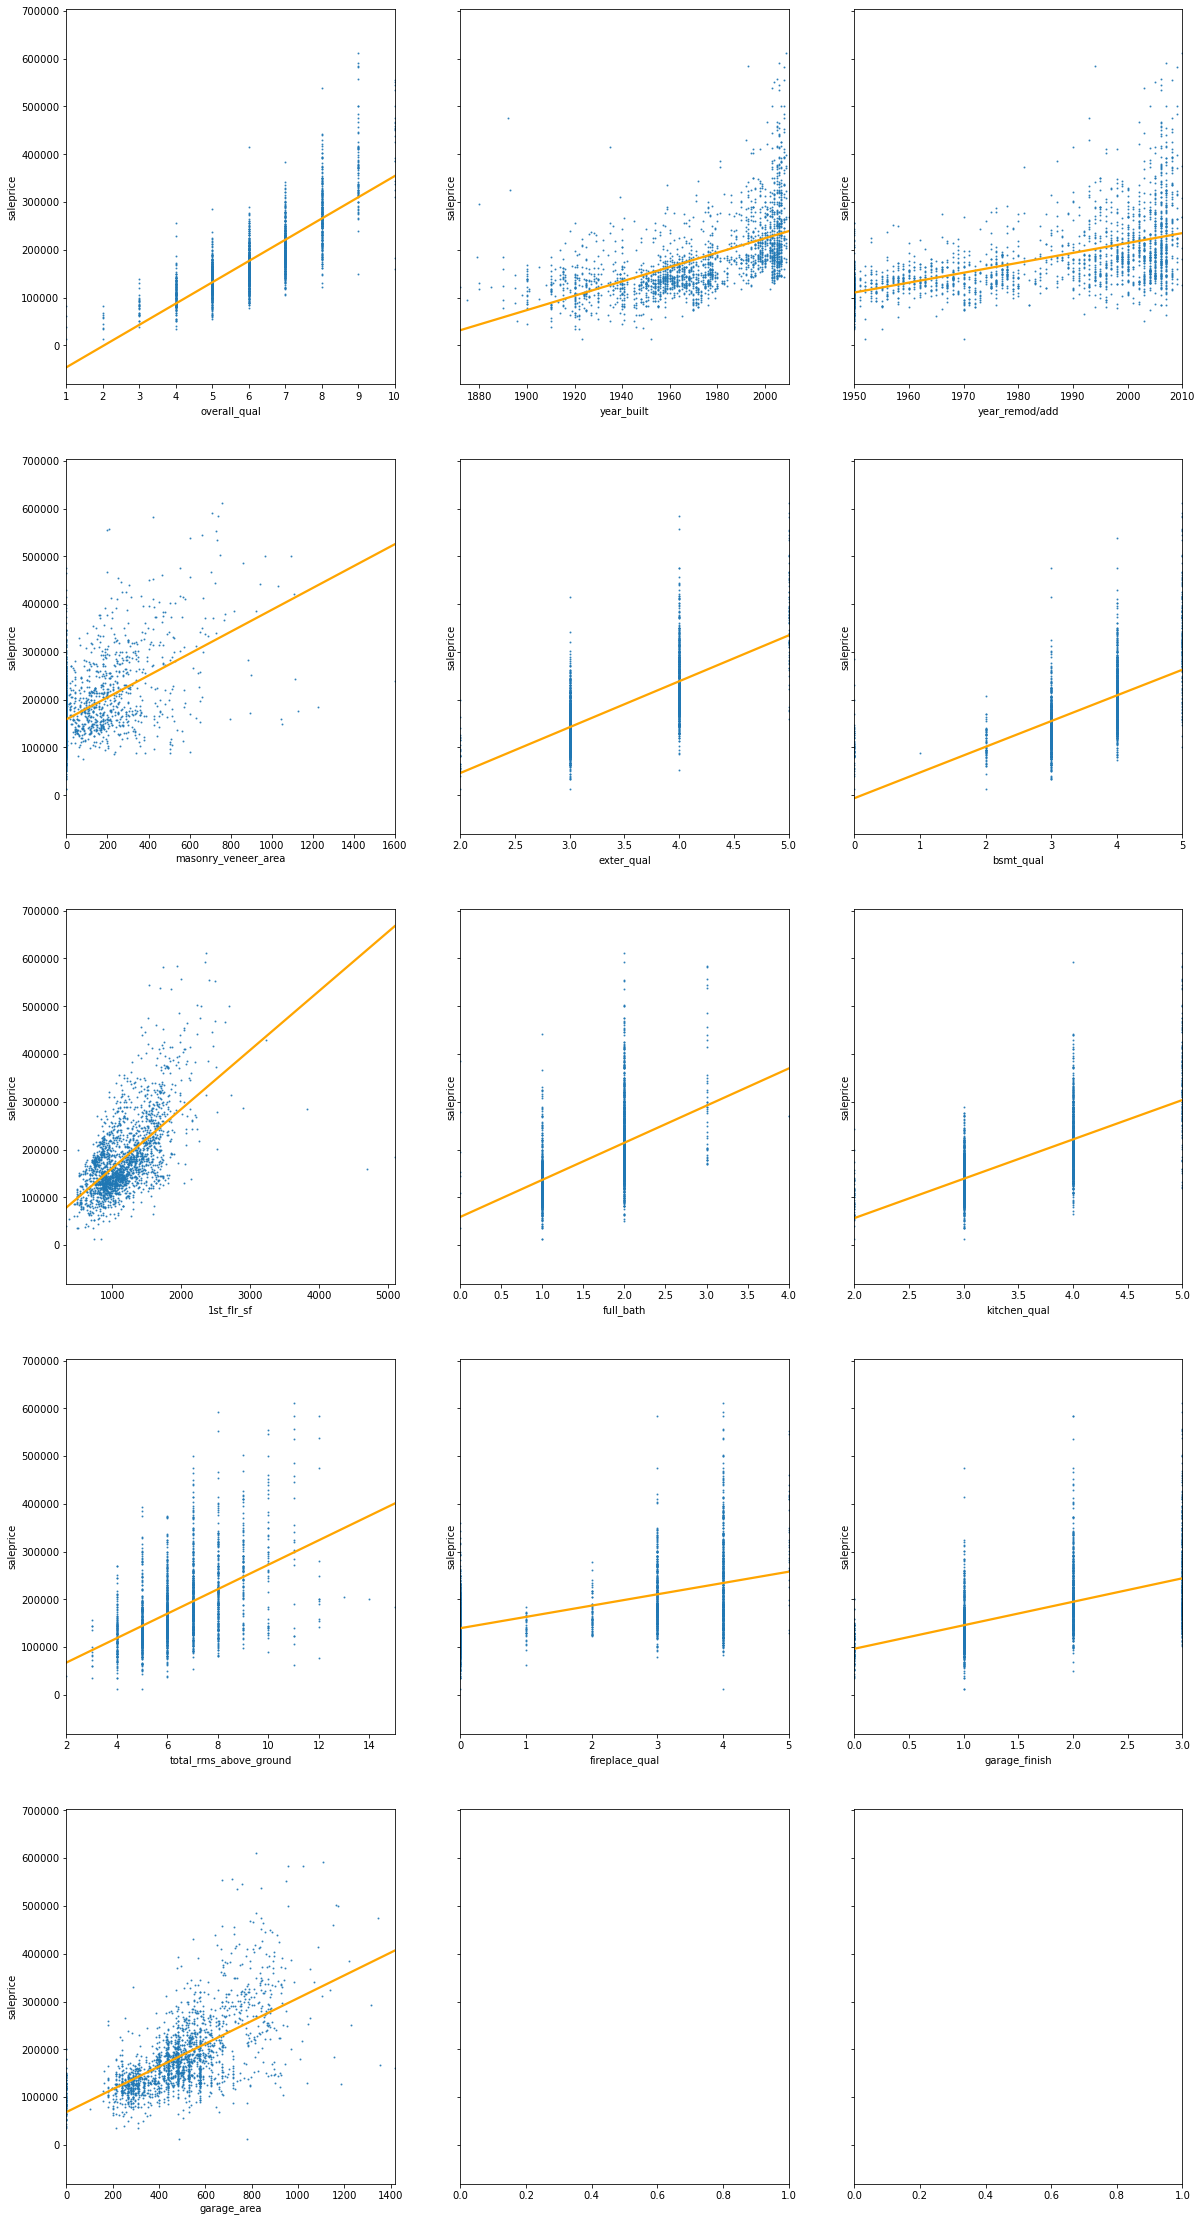

In [37]:
# Plot scatterplots to identify the linearity of the data
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(20,40), sharey=True)
ax = ax.flatten()

for idx, col in enumerate(X3.columns):
    sns.regplot(data=X3, x=col, y=train3_trimmed.saleprice,ci=None, ax=ax[idx],scatter_kws = {'s':1}, line_kws = {'color': 'orange'})
    
plt.savefig(fname='../images/scatter.png')

As the scatterplots above show, the features selected have a fairly linear relationship with the target. However, the relationship also looks like it might be non-linear. Hence, we might be able to try using polynomial regression.

---  
## Polynomialfeatures, Standard scaling, log transformations and regularization

To further improve our model, we will do some transformations. We will first create some polynomial features. we will scale the features using standardscaler so that they have a normal distribution.  
Further, we will use ridge regression to avoid multicollinearity within the polynomial features we have created.

In [38]:
# Create new X and y for the polynomial model, as well as a new train and test dataset
X4 = train3[selected_columns]
y4 = train3.saleprice
test_X4 = test3[selected_columns]
train4 = X4.join(y4)

In [39]:
# Instantiate the polynomialfeatures transformer, setting degrees to 2
# and interaction_only set to true to only get interaction features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [40]:
# Fit the X to the transformer
X_overfit = pd.DataFrame(poly.fit_transform(X4), columns = poly.get_feature_names(X4.columns))
test_overfit = pd.DataFrame(poly.transform(test_X4), columns = poly.get_feature_names(test_X4.columns))

In [41]:
# Create train test splits for the data
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_overfit, y4, test_size = 0.2, random_state = 42)

In [42]:
# Instantiate the StandardScaler and fit and scale the new train and test set
ss = StandardScaler()
Z_train = ss.fit_transform(X_train4)
Z_test = ss.transform(X_test4)

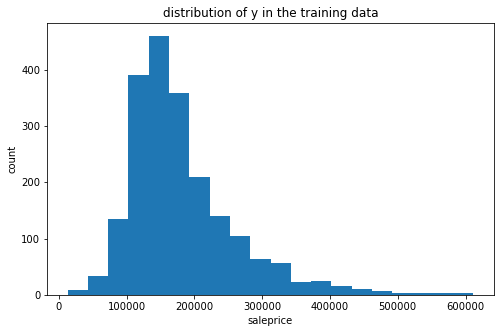

In [43]:
# Plot a histogram of the target (saleprice)
plt.figure(figsize=(8,5))
plt.hist(y4, bins = 20)
plt.title('distribution of y in the training data')
plt.xlabel('saleprice')
plt.ylabel('count')
plt.savefig(fname='../images/y_dist.png')

As we can see from the histogram, the distribution of the target variable is right-skewed, with the peak being left of the center and with a more gradual tapering on the right. Hence it might be wise to do a log transformation on the target variable to normalize this.

In [44]:
# We perform log transformation
y_train4_log = np.log(y_train4)
y_test4_log = np.log(y_test4)

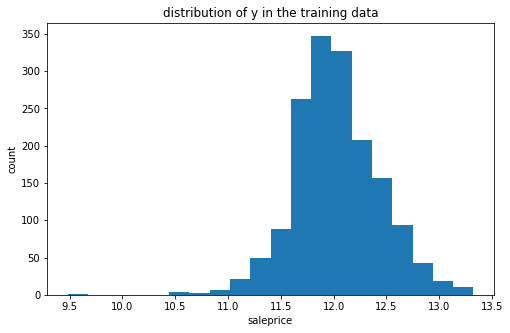

In [45]:
# Plot a histogram of the target (saleprice) after log transformation
plt.figure(figsize=(8,5))
plt.hist(y_train4_log, bins = 20)
plt.title('distribution of y in the training data')
plt.xlabel('saleprice')
plt.ylabel('count')
plt.savefig(fname='../images/y_dist_log.png')

As you can see, the target variable now has a more normal distribution.

In [46]:
# Check the shapes of the data to make sure they are matching
print(f'Z_train shape is: {Z_train.shape}')
print(f'y_train shape is: {y_train4_log.shape}')
print(f'Z_test shape is: {Z_test.shape}')
print(f'y_test shape is: {y_test4_log.shape}')

Z_train shape is: (1640, 91)
y_train shape is: (1640,)
Z_test shape is: (411, 91)
y_test shape is: (411,)


In [47]:
# Instantiate and fit the linearregression model to the split training data
lr4 = LinearRegression()
lr4.fit(Z_train, y_train4_log)

LinearRegression()

In [48]:
# Make predictions on the split training and testing data
# We use np.exp to calculate the exponentials of the predictions as we did a log transformation on y
lr4_pred = np.exp(lr4.predict(Z_test))
lr4_train_pred = np.exp(lr4.predict(Z_train))

In [49]:
# Score the model based on R2 value and RMSE
print(f'The R2 value of the training data is {lr4.score(Z_train, y_train4_log)}.')
print(f'The R2 value of the test data is {lr4.score(Z_test, y_test4_log)}.')
print(f'The RMSE of the training data is {metrics.mean_squared_error(y_train4, lr4_train_pred, squared=False)}')
print(f'The RMSE of the test data is {metrics.mean_squared_error(y_test4, lr4_pred, squared=False)}')

The R2 value of the training data is 0.8702616458380511.
The R2 value of the test data is 0.8347800507801303.
The RMSE of the training data is 27492.19400420829
The RMSE of the test data is 27878.09072599736


Using polynomialfeatures and standard scaling, we can see that there is much less error in the model.  
The $R^2$ scores between the test and training data are closer, and so is the RMSE.  
The RMSE has decreased from the previous model by around 5000, which is good, as this means that there is less error in the predicted data. However, the test RMSE is slightly higher than the training RMSE.  
With a high $R^2$ score, the model is able to explain most of the variance in the predictions.

---
## Testing ridge regression in case there is multicollinearity

We will perform ridge regression on the dataset in case there is multicollinearity.

In [50]:
# Instantiate ridgeCV, create alphas and fit it to the split training data
ridge_alphas = np.logspace(0,10,500)
ridge4 = RidgeCV(alphas=ridge_alphas, cv=5, scoring = 'r2')
# Fit the data to the estimator
ridge4.fit(Z_train, y_train4_log);

In [51]:
# Use the ridge model to predit the split training and testing data
# We use np.exp to calculate the exponentials of the predictions as we did a log transformation on y
ridge_train_pred = np.exp(ridge4.predict(Z_train))
ridge_test_pred = np.exp(ridge4.predict(Z_test))

In [52]:
# Score the model based on R2 value and RMSE
print(f'The R2 value of the training data is {ridge4.score(Z_train, y_train4_log)}.')
print(f'The R2 value of the test data is {ridge4.score(Z_test, y_test4_log)}.')
print(f'The RMSE of the training data is {metrics.mean_squared_error(y_train4, ridge_train_pred, squared=False)}')
print(f'The RMSE of the test data is {metrics.mean_squared_error(y_test4, ridge_test_pred, squared=False)}')


The R2 value of the training data is 0.8608072016630297.
The R2 value of the test data is 0.8312880023020669.
The RMSE of the training data is 28200.39083330392
The RMSE of the test data is 27478.711633057253


In [53]:
# Create a dataframe with the coefficients for each feature
feature_coefs = pd.DataFrame(zip(poly.get_feature_names(X4.columns),ridge4.coef_), columns = ['feature','coefficient'])
# Trim the dataframe to the original features (without polyfeatures)
feature_coefs = feature_coefs[0:13]

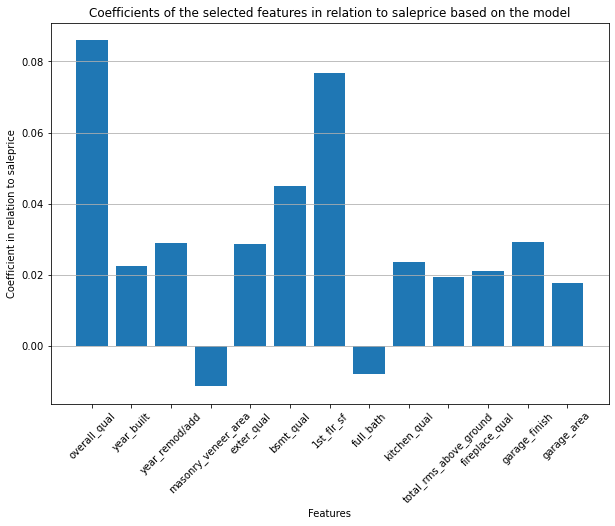

In [54]:
# Plot barchart of coefficients of the main selected features in relation to saleprice
plt.figure(figsize=(10,7))
plt.bar(feature_coefs.feature, feature_coefs.coefficient)
plt.title('Coefficients of the selected features in relation to saleprice based on the model')
plt.xlabel('Features')
plt.xticks(rotation = 45)
plt.ylabel('Coefficient in relation to saleprice')
plt.grid(b=True, which='both',axis='y')
plt.savefig(fname='../images/coefs.png')

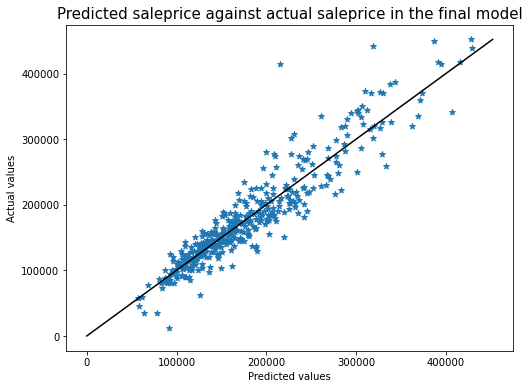

In [55]:
# Plot predicted values against actual values in the train/test split.
plt.figure(figsize=(8,6))
plt.scatter(ridge_test_pred,y_test4,marker = '*')
plt.title('Predicted saleprice against actual saleprice in the final model', fontsize=15)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')

# Plot 'perfect model' line
plt.plot([0,np.max(y_test4)],[0,np.max(y_test4)], c = 'k');
plt.savefig(fname='../images/model4.png')

As can be seen, the two major problems identified in the previous model has been solved:  
1. There is no longer a huge outlier in the predicted price which is very far from the actual saleprice.
2. There are no negative predicted saleprices, or predicted saleprices close to zero.  

The model has a low variance for prediction of prices in the midrange, but as we go to higher sale prices, the variance is higher. Hence, the model may not be the best at predicting higher prices.  

This may be due to a lack of data for higher priced properties in the training set, and the model can be improved if we train it with more data for higher priced properties.

### Evaluating the Ridge model  

The $R^2$ value of the training data is 0.8608072016630297.  
The $R^2$ value of the test data is 0.8312880023020669.  
The RMSE of the training data is 28200.39083330392  
The RMSE of the test data is 27478.711633057253  

Based on the $R^2$ and RMSE scores above, we can see that the train and test scores are now fairly close. The $R^2$ score is 0.83 for the test data, which means that it can explain 83% of the variance around the mean.   
The accuracy is now higher, and the model was able to generalize well into the new data from the test set.  

# Hypothesis testing

#### 𝐻0: There is no correlation between the top 13 features and the saleprice of houses in the Ames Housing Dataset
𝐻0: $\rho = 0$
#### 𝐻𝐴: There is a correlation between the top 13 features and the saleprice of houses in the Ames Housing Dataset
𝐻𝐴: $\rho ≠ 0$

Independent variables:
1. 'overall_qual'  
2.  'year_built'  
3.  'year_remod/add'  
4.  'masonry_veneer_area'  
5.  'exter_qual'  
6.  'bsmt_qual'  
7.  '1st_flr_sf'  
8.  'full_bath'  
9.  'kitchen_qual'  
10. 'total_rms_above_ground'  
11. 'fireplace_qual'  
12. 'garage_finish'  
13. 'garage_area'  

Dependent variables = 'saleprice'

Significance level: 0.385% (adjusted down for the Bonferroni correction)

In [56]:
# Create a function that will perform the Pearson-R test and add the results to a dataframe for each feature

def test_pearsonr(feature_list):
    # Initiate empty data list
    data = []
    # Create dataframe of X values after standardscaler for the main features
    Z_train_df = pd.DataFrame(Z_train, columns = poly.get_feature_names(X4.columns))
    # Iterate through each feature to perform the pearsonr test
    for feature in feature_list:
        ttest = stats.pearsonr(Z_train_df[feature], y_train4)
        # Add the results into the list
        data.append([feature, ttest[0], ttest[1]])
    # Create a dataframe from the data list
    pearsonr_df = pd.DataFrame(data=data, columns=['feature','corr_coef','p_val'])
    # Return the dataframe
    return pearsonr_df.sort_values('corr_coef',ascending = False)

In [57]:
# Perform Pearson-R test on the selected features
test_pearsonr(selected_columns)

,feature,corr_coef,p_val
0,overall_qual,0.795353,0.000000e+00
4,exter_qual,0.714423,2.634365e-256
8,kitchen_qual,0.689440,1.107714e-231
12,garage_area,0.649681,2.804512e-197
6,1st_flr_sf,0.606965,1.172811e-165
5,bsmt_qual,0.603626,2.192299e-163
1,year_built,0.568881,2.900835e-141
11,garage_finish,0.553657,2.235162e-132
2,year_remod/add,0.549513,4.897255e-130
7,full_bath,0.539412,1.815179e-124


Given the extremely low p-values of the tests, which are all below the significance level, we can comfortably say that the correlations did not happen at random given a true null hypothesis.  
Therefore, the null hypothesis can be rejected and we can accept the alternative hypothesis that there is a correlation between the features and saleprice of houses in the Ames housing dataset.

This correlation is strongly positive as given in the correlation coefficients above.
 
---

# Conclusion / recommendations

Based on the hypothesis testing, we can safely (and almost certainly) reject the null hypothesis that there is no correlation between the features and saleprice of houses in the Ames housing dataset.  

The alternative hypothesis that there is a correlation between the top 13 features and saleprice of houses in the Ames housing dataset is therefore accepted.  

This correlation is strongly positive, between 0.51 and 0.79, which means that the presence of these features are more likely to increase the saleprice rather than not increasing it.  

The top 13 features which the director should look out for are:  
1. 'overall_qual'  
2.  'year_built'  
3.  'year_remod/add'  
4.  'masonry_veneer_area'  
5.  'exter_qual'  
6.  'bsmt_qual'  
7.  '1st_flr_sf'  
8.  'full_bath'  
9.  'kitchen_qual'  
10. 'total_rms_above_ground'  
11. 'fireplace_qual'  
12. 'garage_finish'  
13. 'garage_area'  

While we only listed the top 13 features, there is a possibility that there are other features which may strongly affect the saleprice.  

Using these top 13 features, we fitted a regression model to predict the saleprice. This model ended up with an $R^2$ score of around 0.83 which means it explains the variance of the predicted values around the mean fairly well.  

Its RMSE was also lower than the previous models, and there was not a big difference between the train and test RMSE, meaning that it was fairly accurate.  

It was able to generalize decently to the new data from the test set in the train-test-split.  
Hence, we can conclude that this model should perform decently in predicting saleprice for Property Flippers Co as a comparison of whether a house they are considering is undervalued.  

However, the model is not as good at predicting higher priced properties, possibly due to a lack of data for higher priced properties in the training set, and the model can be improved if we train it with more data for higher priced properties.


---
## Kaggle model

We will use the above model for our Kaggle submission.

In [58]:
# Create new X and y for the polynomial model, as well as a new train and test dataset
X_kag = train3[selected_columns]
y_kag = train3.saleprice
test_kag = test3[selected_columns]
train_kag = X_kag.join(y_kag)

In [59]:
# Instantiate the polynomialfeatures transformer, setting degrees to 2
# and interaction_only set to true to only get interaction features
poly_kag = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [60]:
# Fit the X to the transformer
train_overfit = pd.DataFrame(poly_kag.fit_transform(X_kag), columns = poly_kag.get_feature_names(X_kag.columns))
test_overfit = pd.DataFrame(poly_kag.transform(test_kag), columns = poly_kag.get_feature_names(test_kag.columns))

In [61]:
# Instantiate the StandardScaler and fit and scale the new train and test set
ss_kag = StandardScaler()
Z_train_kag = ss.fit_transform(train_overfit)
Z_test_kag = ss.transform(test_overfit)

In [62]:
# We perform log transformation on target
y_kag_log = np.log(y_kag)

In [63]:
# Check the shapes of the data to make sure they are matching
print(f'Z_train_kag shape is: {Z_train_kag.shape}')
print(f'y_train_kag shape is: {y_kag_log.shape}')
print(f'Z_test_kag shape is: {Z_test_kag.shape}')


Z_train_kag shape is: (2051, 91)
y_train_kag shape is: (2051,)
Z_test_kag shape is: (878, 91)


In [64]:
# Instantiate ridgeCV, create alphas and fit it to the split training data
ridge_alphas = np.logspace(0,10,500)
ridge_kag = RidgeCV(alphas=ridge_alphas, cv=5, scoring = 'r2')
# Fit the data to the estimator
ridge_kag.fit(Z_train_kag, y_kag_log);

In [65]:
# Use the ridge model to predit the split training and testing data
# We use np.exp to calculate the exponentials of the predictions as we did a log transformation on y
kag_train_pred = np.exp(ridge_kag.predict(Z_train_kag))
kag_test_pred = np.exp(ridge_kag.predict(Z_test_kag))

In [66]:
# Score the model based on R2 value and RMSE
print(f'The R2 value of the training data is {ridge_kag.score(Z_train_kag, y_kag_log)}.')
print(f'The RMSE of the training data is {metrics.mean_squared_error(y_kag, kag_train_pred, squared=False)}')

The R2 value of the training data is 0.8572431189334878.
The RMSE of the training data is 27916.742218245592


In [67]:
# Place the kaggle model in a dataframe and save it for submission
kaggle = pd.DataFrame(test3.id)
kaggle['saleprice'] = kag_test_pred
kaggle.to_csv('../data/kaggle.csv',index=False)